In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"varrasqi","key":"b643a9473e1b3b8568a09e538279d0f0"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d 'madisona/translated-animals10'

 97% 569M/586M [00:06<00:00, 85.9MB/s]
100% 586M/586M [00:06<00:00, 98.0MB/s]


In [6]:
import zipfile

dataset_zip = zipfile.ZipFile('translated-animals10.zip')

dataset_zip.extractall()

dataset_zip.close()

In [7]:
import os

animals = os.path.join('animals10/raw-img')

print(os.listdir(animals))

['butterfly', 'squirrel', 'sheep', 'spider', 'horse', 'elephant', 'dog', 'cat', 'cow', 'chicken']


In [8]:
import shutil

ignore_animals = ['squirrel', 'dog', 'elephant', 'chicken', 'cow', 'horse']

for x in ignore_animals:
  path = os.path.join(animals, x)
  shutil.rmtree(path)

In [9]:
list_animals = os.listdir(animals)
print(list_animals)

['butterfly', 'sheep', 'spider', 'cat']


In [10]:
from PIL import Image
total = 0

for x in list_animals:
  dir = os.path.join(animals, x)
  y = len(os.listdir(dir))
  print(x+':', y)
  total = total + y

  img_name = os.listdir(dir)
  for z in range(4):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')

print('\nTotal :', total)

butterfly: 2112
- (640, 454)
- (300, 200)
- (300, 225)
- (300, 225)
---------------
sheep: 1820
- (300, 300)
- (300, 225)
- (300, 186)
- (300, 208)
---------------
spider: 4821
- (300, 200)
- (273, 300)
- (300, 284)
- (216, 300)
---------------
cat: 1668
- (640, 426)
- (300, 169)
- (282, 300)
- (300, 240)
---------------

Total : 10421


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

<function matplotlib.pyplot.show(close=None, block=None)>

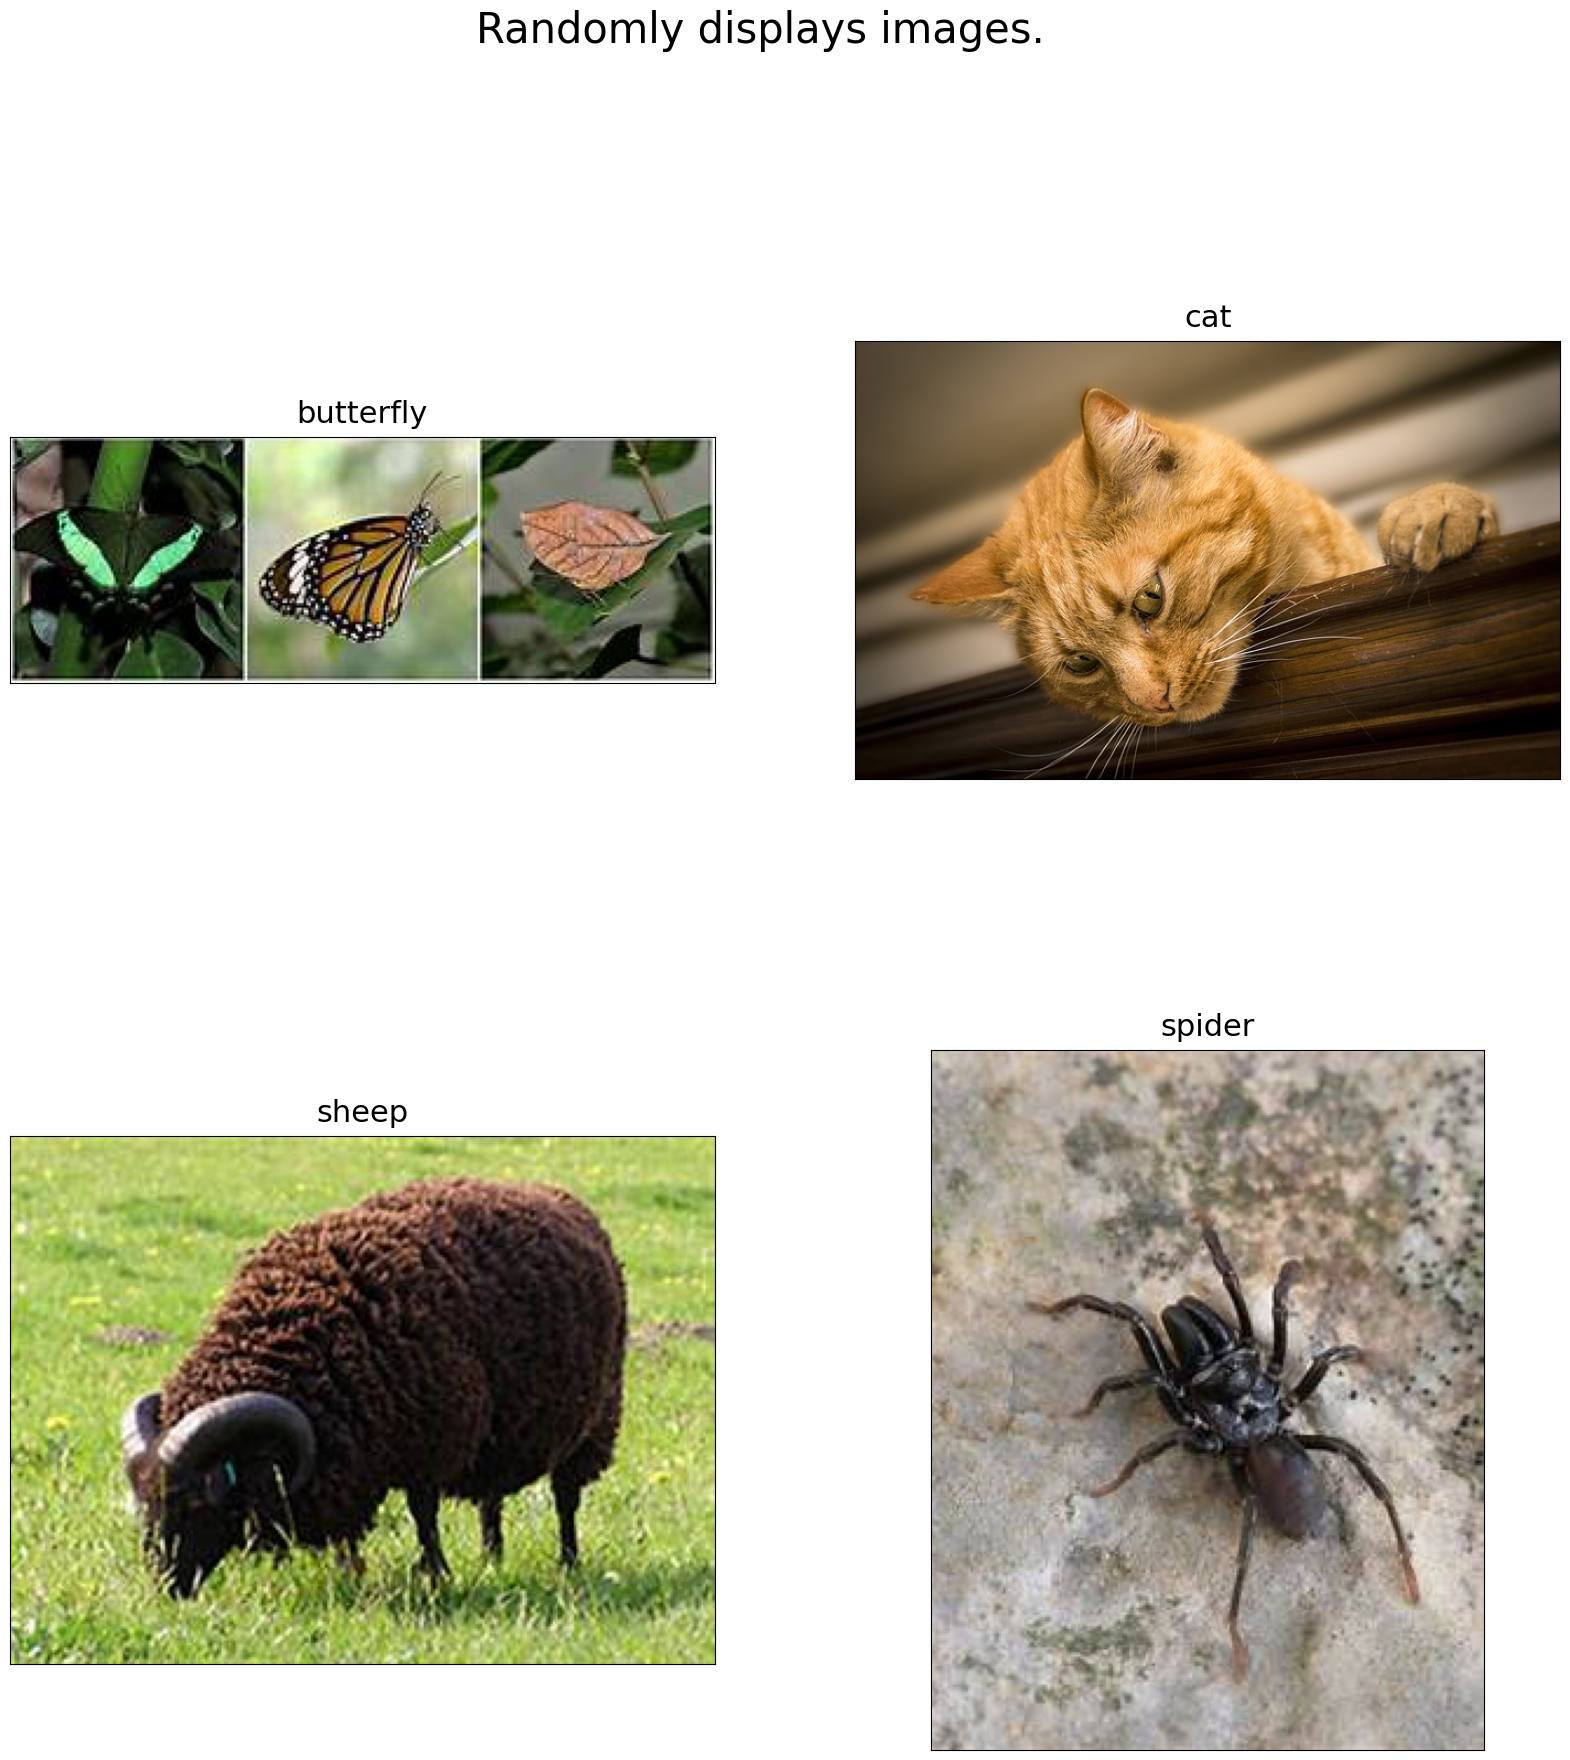

In [12]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(20,20))
fig.suptitle("Randomly displays images.", fontsize=30)
animals_sorted = sorted(list_animals)
animals_id = 0
for i in range(2):
  for j in range(2):
    try:
      animals_selected = animals_sorted[animals_id]
      animals_id += 1
    except:
      break
    if animals_selected == '.TEMP':
        continue
    animals_selected_images = os.listdir(os.path.join(animals, animals_selected))
    animals_selected_random = np.random.choice(animals_selected_images)
    img = plt.imread(os.path.join(animals, animals_selected, animals_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(animals_selected, pad=10, fontsize=22)

plt.setp(ax, xticks=[],yticks=[])
plt.show

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [14]:
batch_size = 256

data_train = train_datagen.flow_from_directory(
    animals,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

data_val = train_datagen.flow_from_directory(
    animals,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 8338 images belonging to 4 classes.
Found 2083 images belonging to 4 classes.


In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.91):
      print("\nAccuracy above 92%, finish training!")
      self.model.stop_training = True

callbacks = myCallback()

In [17]:
history = model.fit(data_train,
                    epochs = 500,
                    steps_per_epoch = data_train.samples // batch_size,
                    validation_data = data_val,
                    validation_steps = data_val.samples // batch_size,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/500
32/32 [==============================] - 97s 3s/step - loss: 1.2522 - accuracy: 0.4796 - val_loss: 1.0858 - val_accuracy: 0.5342
Epoch 2/500
32/32 [==============================] - 73s 2s/step - loss: 1.0471 - accuracy: 0.5448 - val_loss: 0.9910 - val_accuracy: 0.5874
Epoch 3/500
32/32 [==============================] - 80s 3s/step - loss: 0.9290 - accuracy: 0.6159 - val_loss: 0.8948 - val_accuracy: 0.6353
Epoch 4/500
32/32 [==============================] - 82s 3s/step - loss: 0.8927 - accuracy: 0.6364 - val_loss: 0.8581 - val_accuracy: 0.6519
Epoch 5/500
32/32 [==============================] - 74s 2s/step - loss: 0.8727 - accuracy: 0.6528 - val_loss: 0.7834 - val_accuracy: 0.6963
Epoch 6/500
32/32 [==============================] - 80s 3s/step - loss: 0.8156 - accuracy: 0.6818 - val_loss: 0.7552 - val_accuracy: 0.6929
Epoch 7/500
32/32 [==============================] - 81s 3s/step - loss: 0.7765 - accuracy: 0.6978 - val_loss: 0.7134 - val_accuracy: 0.7178
Epoch 8/500
3

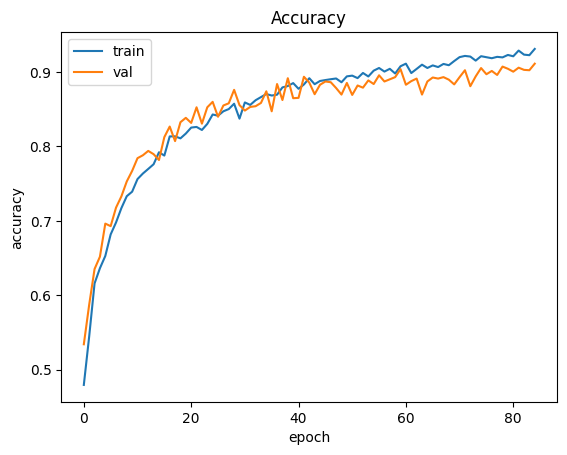

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

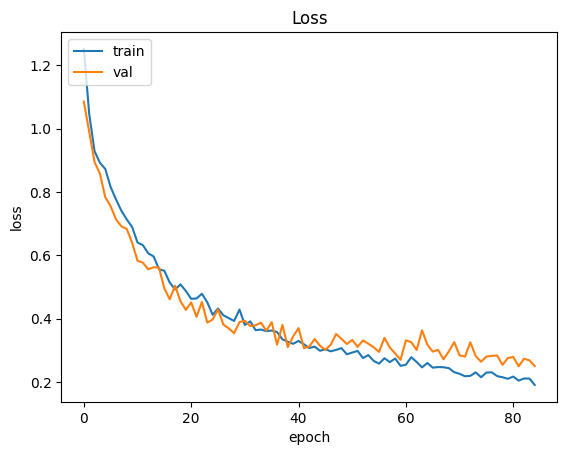

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('SavedModel.tflite', 'wb') as f:
  f.write(tflite_model)

In [22]:
!ls -la | grep 'SavedModel'

-rw-r--r-- 1 root root  13900760 Dec 17 06:18 SavedModel.tflite
